In [1]:
import tensorflow as tf
print("cuDNN version:", tf.sysconfig.get_build_info().get("cudnn_version", "Not found"))
print("CUDA version:", tf.sysconfig.get_build_info().get("cuda_version", "Not found"))

2024-12-24 17:22:20.065757: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-24 17:22:20.074197: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735053740.084569  131838 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735053740.087385  131838 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 17:22:20.097800: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

cuDNN version: 9
CUDA version: 12.5.1


In [2]:
import tensorflow as tf
print("Is GPU available:", tf.test.is_gpu_available())
print("List of GPUs:", tf.config.list_physical_devices('GPU'))

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is GPU available: True
List of GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1735053741.230638  131838 gpu_device.cc:2022] Created device /device:GPU:0 with 22120 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


In [3]:
import numpy as np
from transformers import DetrImageProcessor, DetrForObjectDetection
from transformers import YolosImageProcessor, YolosForObjectDetection
from transformers import AutoImageProcessor, AutoModelForObjectDetection
import torch
import cv2
import requests
from PIL import Image, ImageDraw, ImageFont
import json


In [4]:
# завантажимо та перевіримо чи все працює, для цього використаємо код з документації. трохи модифікувавши його



# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)

# image = Image.open("imgs/test.jpeg")
image = Image.open("imgs/tst3.jpeg")
# you can specify the revision tag if you don't want the timm dependency
processor = DetrImageProcessor.from_pretrained("facebook/detr-resnet-101", revision="no_timm")
model = DetrForObjectDetection.from_pretrained("facebook/detr-resnet-101", revision="no_timm")

inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# convert outputs (bounding boxes and class logits) to COCO API
# let's only keep detections with score > 0.9
target_sizes = torch.tensor([image.size[::-1]])
results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=0.7)[0]

# Копіювання зображення для малювання
image_with_boxes = image.copy()
draw = ImageDraw.Draw(image_with_boxes)

# Встановлення шрифту для тексту
try:
    font = ImageFont.truetype("arial.ttf", size=15)
except IOError:
    font = ImageFont.load_default()

for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    lbl = model.config.id2label[label.item()]
    print(
            f"Detected {lbl} with confidence "
            f"{round(score.item(), 3)} at location {box}"
    )
    label_text = f"{label}: {round(score.item(), 2)}"

    draw.rectangle(box, outline="green", width=3)
    
    # Додавання тексту
    text_position = (box[0], box[1] - 10 if box[1] - 10 > 0 else box[1] + 5) # виводимо текст на 10 пікселів вище, якщо вилітаємо за зображення - на 5 пікселів нижче рамки
    draw.text(text_position, f"{lbl}_{round(score.item() * 100, 1)}", fill="green", font=font)

# Збереження зображення
output_path = "detr-resnet-101_detection_result.jpg"
image_with_boxes.save(output_path)
print(f"Зображення збережено як {output_path}")

Detected truck with confidence 0.772 at location [195.49, 427.92, 213.19, 448.66]
Detected car with confidence 0.91 at location [282.07, 533.31, 306.63, 560.55]
Detected car with confidence 0.731 at location [121.57, 338.51, 139.12, 353.04]
Detected car with confidence 0.983 at location [81.26, 225.61, 100.44, 235.67]
Detected car with confidence 0.959 at location [140.04, 496.72, 164.68, 510.54]
Detected car with confidence 0.951 at location [340.44, 391.15, 359.81, 404.79]
Detected car with confidence 0.966 at location [109.76, 483.83, 136.36, 497.85]
Detected car with confidence 0.889 at location [196.27, 428.58, 213.21, 448.26]
Detected car with confidence 0.891 at location [188.69, 215.68, 199.47, 224.66]
Detected car with confidence 0.937 at location [142.43, 222.96, 157.29, 233.71]
Detected car with confidence 0.797 at location [208.9, 468.93, 226.47, 488.23]
Detected car with confidence 0.975 at location [162.04, 218.54, 176.75, 229.94]
Detected car with confidence 0.902 at loc

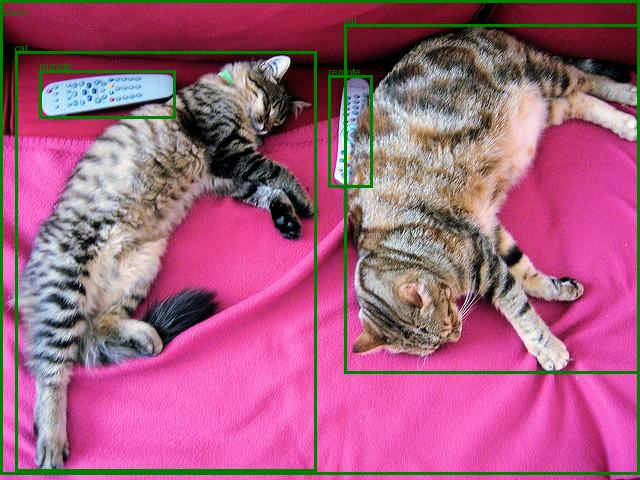

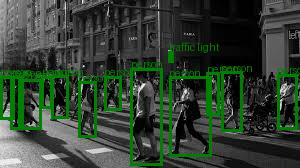

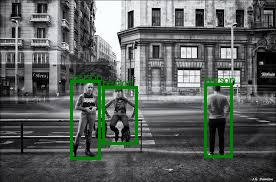

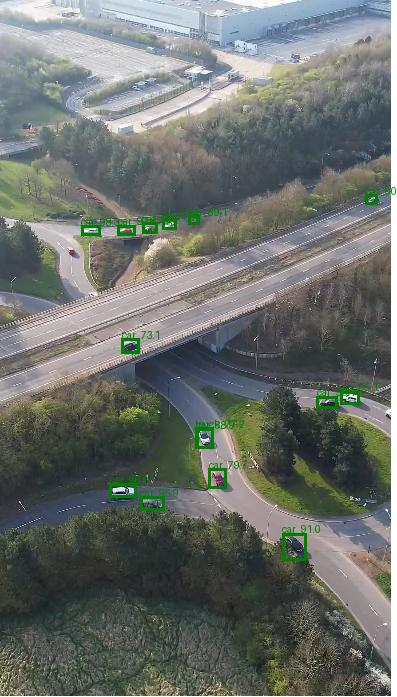

 тут довелось зменшити trashold та всеодно задетектило не всі авто

In [5]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

model = YolosForObjectDetection.from_pretrained('hustvl/yolos-tiny')
image_processor = YolosImageProcessor.from_pretrained("hustvl/yolos-tiny")

inputs = image_processor(images=image, return_tensors="pt")
outputs = model(**inputs)

# model predicts bounding boxes and corresponding COCO classes
logits = outputs.logits
bboxes = outputs.pred_boxes


# print results
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=target_sizes)[0]
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}")

Detected remote with confidence 0.991 at location [46.48, 72.78, 178.98, 119.3]
Detected remote with confidence 0.908 at location [336.48, 79.27, 368.23, 192.36]
Detected cat with confidence 0.934 at location [337.18, 18.06, 638.14, 373.09]
Detected cat with confidence 0.979 at location [10.93, 53.74, 313.41, 470.67]
Detected remote with confidence 0.974 at location [41.63, 72.23, 178.09, 119.99]


тепер подамо на вхід відео, на виході отримаємо копію відео але вже з обведенеми об'єктами

In [6]:
processor = AutoImageProcessor.from_pretrained("hustvl/yolos-tiny")
model = AutoModelForObjectDetection.from_pretrained("hustvl/yolos-tiny")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Використовується пристрій:", device)  

# Переміщення моделі на GPU
model = model.to(device)

Використовується пристрій: cuda


In [7]:
def get_prediction(processor, model, img, threshold=0.7) -> dict:
    height, width, _ = img.shape # отримуємо розмір зображення
    target_sizes = torch.tensor([[height, width]]).to(model.device)
    inputs = processor(images=img, return_tensors="pt")
    inputs = {key: value.to(model.device) for key, value in inputs.items()}  # Переміщення даних
    outputs = model(**inputs)
    # використання target_size необхідно щоб модель могла прийняти зображення будь-якого розміру, зменшити його до свого робочого, а потім реконструює координати 
    # bboxes до розмірів оригівналоьного зображення

    results = processor.post_process_object_detection(outputs, target_sizes=target_sizes, threshold=threshold)[0]
    return results

In [12]:
def visualise(frame, results, fps, targets=[]):
    cv2.putText(frame, f"FPS: {round(fps, 1)}", (20, 20), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
      lbl = model.config.id2label[label.item()]

      if lbl in targets or not targets:  # це дозволяє обирати детекції яких саме об'єктів ми бажаємо візуалізувати
        box_list = box.tolist()
        box = [int(i) for i in box_list] # значення в box раціональні, потрібно перетворити в цілі
        detect_score = round(score.item() * 100, 2)
      
        cv2.rectangle(frame, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 3)
        cv2.putText(frame, f"{lbl}_{detect_score}", (box[0], box[1] - 10 if box[1] - 10 > 0 else box[1] + 5), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(0, 255, 0), thickness=2)
    return frame

In [9]:
import time
import os
import json

In [10]:
def proceed_frame(model, path_to_video, targets=[], path_to_save=""):
    cap = cv2.VideoCapture(path_to_video)

    window_name = "proceeded_video"
    cv2.namedWindow(window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(window_name, 800, 600)

    total_frames = 0
    total_time = 0
    if path_to_save:

        if not os.path.exists(path_to_save):
             os.mkdir(path_to_save)

        # Параметри запису відео
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        # fps_input = int(cap.get(cv2.CAP_PROP_FPS))

        # Ініціалізація записувача
        fourcc = cv2.VideoWriter_fourcc(*'VP80')
        video_name = path_to_video.split("/")[-1] if "/" in path_to_video else path_to_video
        out = cv2.VideoWriter(os.path.join(path_to_save, video_name), fourcc, 35, (frame_width, frame_height))

    while True:
        
        ret, frame = cap.read()
        if not ret:
            print("дідько! щось пішло не так!")
            break
        start_time = time.time()
                
        results = get_prediction(processor, model, frame, threshold=0.5)

        elapsed_time = time.time() - start_time
        total_time += elapsed_time
        total_frames += 1
        fps = total_frames / total_time
        
        proceeded_frame = visualise(frame, results, fps, targets=targets)
        cv2.imshow(window_name, proceeded_frame)

        if path_to_save:
            out.write(proceeded_frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
                break
    
        
    cap.release()
    if path_to_save:
         out.release()
    cv2.destroyAllWindows()

In [13]:
proceed_frame(model, path_to_video="videos/test_vid2.webm", targets=["airplane"], path_to_save="proceeded_videos")

OpenCV: FFMPEG: tag 0x30385056/'VP80' is not supported with codec id 139 and format 'webm / WebM'


дідько! щось пішло не так!


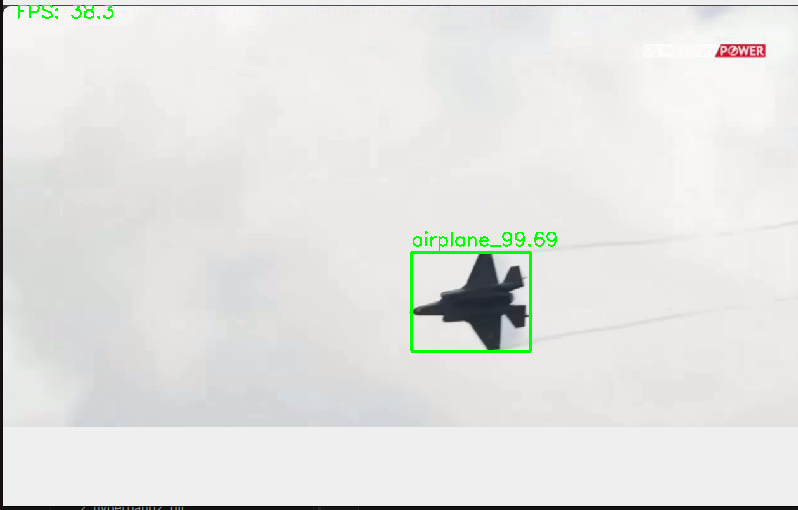



In [ ]:
from transformers import AutoModelForSpeechSeq2Seq, AutoProcessor, pipeline
from datasets import load_dataset


device = "cuda:0" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if torch.cuda.is_available() else torch.float32

model_id = "openai/whisper-large-v3-turbo"

model = AutoModelForSpeechSeq2Seq.from_pretrained(
    model_id, torch_dtype=torch_dtype, low_cpu_mem_usage=False, use_safetensors=True
)
model.to(device)

processor = AutoProcessor.from_pretrained(model_id)

pipe = pipeline(
    "automatic-speech-recognition",
    model=model,
    tokenizer=processor.tokenizer,
    feature_extractor=processor.feature_extractor,
    torch_dtype=torch_dtype,
    device=device,
)

dataset = load_dataset("distil-whisper/librispeech_long", "clean", split="validation")
sample = dataset[0]["audio"]

result = pipe("Kalush Tipok.mp3", return_timestamps=True)
print(result["text"])

Device set to use cuda:0
Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.43.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


 Mr. Quilter is the apostle of the middle classes, and we are glad to welcome his gospel. Nor is Mr. Quilter's manner less interesting than his matter. He tells us that at this festive season of the year, with Christmas and roast beef looming before us, similes drawn from eating and its results occur most readily to the mind. He has grave doubts whether Sir Frederick Layton's work is really Greek after all, and can discover in it but little of rocky Ithaca. Linnell's pictures are a sort of Up Guards and Adam paintings, and Mason's exquisite idles are as national as a jingo poem. Mr. Birkett Foster's landscapes smile at one much in the same way that Mr. Carker used to flash his teeth, and Mr. John Collier gives his sitter a cheerful slap on the back before he says, like a shampooer in a Turkish bath, next man.


In [ ]:
result = pipe("/home/pivden/hilel_machine_learning/hw17/Kalush Tipok.mp3", return_timestamps=True)
text = result["text"]
line_len = 150
lines = [text[i:i+line_len] for i in range(0, len(text), line_len)]

for line in lines:
    print(line)

# Впринципі воно зрозуміло текст пісні кращє ніж я) 

/home/pivden/hilel_machine_learning/hilel_machine_learning/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(
Whisper did not predict an ending timestamp, which can happen if audio is cut off in the middle of a word. Also make sure WhisperTimeStampLogitsProcessor was used during generation.


 Yeah we on the law, on the law, on the law, key Мене не дисне, дали цей стан Передали мене, мене дали мене пах Сык пенний цахпа, пенний пах Передос п
ередайте такого пацанам На базаре мало, мене в сторону кидало Мене мало было свало, мене перебили вдало Но берет, али парушечный берет, а в наборе зор
и, боре вине, беле, долю в тебе гриба, фиг! Новинно чути не сисьли, не винный так цини, но винный тинни, да ви на провину. Кутуш падает, тикки-пау! Зо
лото на дни стакана тече набором бум Болото в мене печено, колона водить шум Засей висам кості бро, бо він робить бадабум Золото на дни стакана поки н
е передумав Тренді круто, тренді брод, так припруто принятро Тріпсу стрепу, чо так препу, пак, зо трепу, фу, канатал, пуп Переменедали, перебило, пона
фали за медали, нові крали в тілі Мене ніби було, бурються не передати Аппараты бы мне надо быть не были, чтобы маты чуть сидеть в аппарата Труцем, тр
уцем, труцем, чё? Часу на пас на тары, ты как прав, короба так палит По передах, берите им, ба

In [31]:
result = pipe("/home/pivden/Music/ramstien_-_los_(z3.fm).mp3", return_timestamps=True)
text = result["text"]
line_len = 150
lines = [text[i:i+line_len] for i in range(0, len(text), line_len)]

for line in lines:
    print(line)

/home/pivden/hilel_machine_learning/hilel_machine_learning/lib/python3.10/site-packages/transformers/models/whisper/generation_whisper.py:512: FutureWarning: The input name `inputs` is deprecated. Please make sure to use `input_features` instead.
  warnings.warn(


 Wir waren namenlos und ohne Lieder recht wortlos Waren wir nie wieder etwas sanglos Sind wir immer noch dafür nicht klanglos Man hört uns doch nach e
inem Windstoß Ging ein Sturm los, einfach beispiellos Es wurde zeitlos Sie waren sprachlos So sehr schockiert und sehr ratlos Was war passiert? Etwas 
fassungslos Und garantiert verständnislos Das wird zensiert, sie sagten grundlos Schade um die Noten, so schamlos Das gehört verboten, es ist geistlos
 Was sie da probieren, sind geschmacklos Wie sie musizieren, es ist hoffnungslos Sinnlos Hilflos Sie sind Gott Los Wir waren namenlos Wir haben einen 
Namen waren wortlos. Die Worte kamen etwas sanglos. Sind wir immer noch dafür nicht klanglos? Das hört man doch, wir sind nicht fehlerlos, nur etwas h
altlos. Ihr werdet lautlos und Nählos Wir waren namenlos und ohne Lieder recht wortlos Waren wir nie wieder etwas sanglos Sind wir immer noch dafür ni
cht klanglos Man hört uns doch nach einem Windstoß Ging ein Sturm los, einfach beispiellos, wu

Зручність huggingface у тому що однакові моделі за типом мають однакові методи, що робить досить зручним та швидким пошук моделі для конкретної задачі. Також в майбутньому потрібно буде написати собі перекладач, щоб не чекати озвучки нових серіалів. Або хочаб субтитри накладати)